In [80]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [81]:
from sklearn.model_selection import train_test_split
features = pd.read_csv('train.csv')
targets = features['Survived']
train, cvs, y_train, y_cvs = train_test_split(features, targets, test_size=0.4)
# train = pd.read_csv('train.csv')[:600]
# cvs = pd.read_csv('train.csv')[600:]
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
184,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0000,NaN,S


In [82]:
train['FarePerYear'] = train['Fare']/train['Age']
test['FarePerYear'] = test['Fare']/test['Age']
cvs['FarePerYear'] = cvs['Fare']/cvs['Age']
train['Worth'] = train['Age']/train['Pclass']
test['Worth'] = test['Age']/test['Pclass']
cvs['Worth'] = cvs['Age']/cvs['Pclass']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a179da3c8>,
      dtype=object)

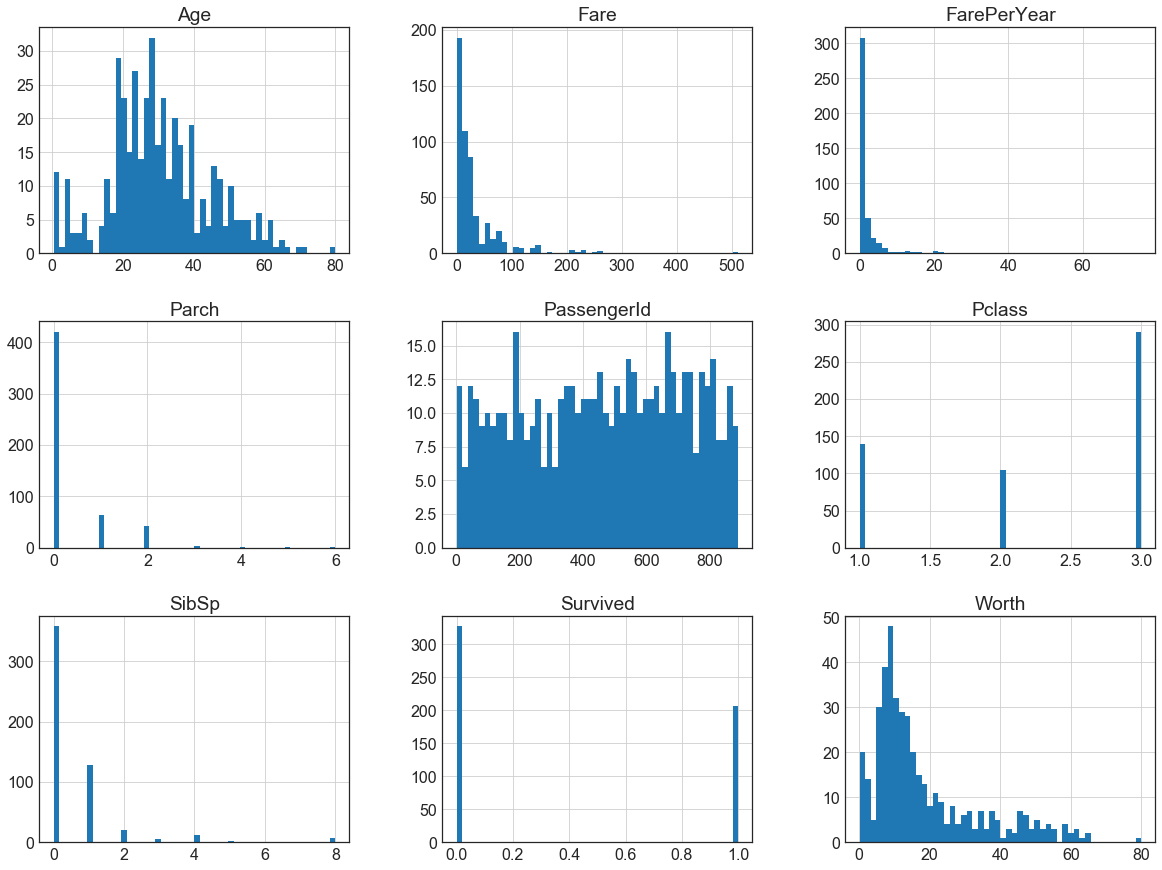

In [83]:
train.hist(bins=50, figsize=(20,15))

In [84]:
women = 0
total = 0
for index, row in train.iterrows():
    if row['Sex'] == 'female':
        women += row['Survived']
        total += 1
print(women/total)

0.7340425531914894


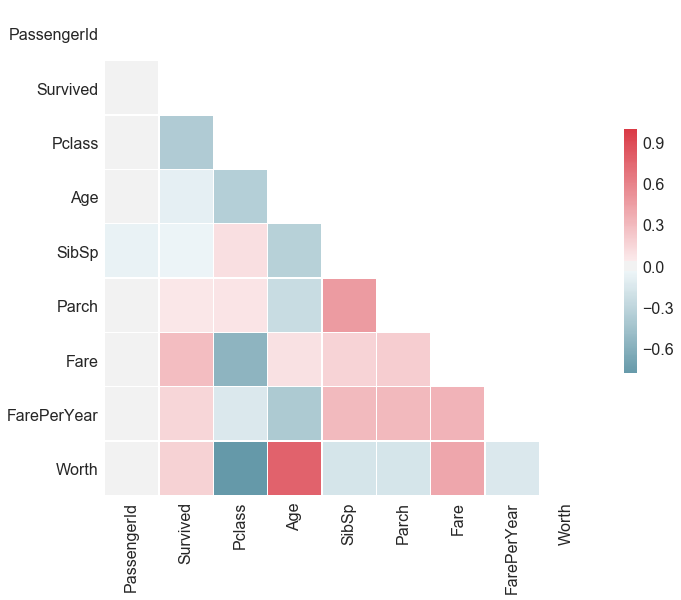

In [85]:
sns.set_style('white')
sns.set_context('paper', font_scale=2)
corr_matrix = train.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1.0, center=0,
           square=True, linewidths=0.5, cbar_kws={'shrink':0.5})

In [86]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["FarePerYear","Age", "SibSp", "Parch", "Fare"])),
        ("imputer", Imputer(strategy="median")),
    ])

In [88]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [89]:
from future_encoders import OneHotEncoder

cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [90]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [91]:
X_train = preprocess_pipeline.fit_transform(train)
y_train = train['Survived']
X_cv = preprocess_pipeline.fit_transform(cvs)
y_cv = cvs['Survived']
X_test = preprocess_pipeline.fit_transform(test)

In [92]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [93]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [2,3,4,5,10], 'n_estimators': [5,10,50,100,500],
    'min_child_weight': [1,2,3,5], 'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_jobs': [1,2,3,5], 'scale_pos_weight': [1,2,5,10]}
]

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [2, 3, 4, 5, 10], 'n_estimators': [5, 10, 50, 100, 500], 'min_child_weight': [1, 2, 3, 5], 'learning_rate': [0.01, 0.1, 0.5, 1], 'n_jobs': [1, 2, 3, 5], 'scale_pos_weight': [1, 2, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [94]:
grid_search.best_params_

{'learning_rate': 0.5,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 5,
 'n_jobs': 1,
 'scale_pos_weight': 1}

In [95]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.46808238975153255 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 1, 'scale_pos_weight': 1}
0.5282293225753986 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 1, 'scale_pos_weight': 2}
0.52645375680342 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 1, 'scale_pos_weight': 5}
0.7343880736345255 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 1, 'scale_pos_weight': 10}
0.46808238975153255 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 1}
0.5282293225753986 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 2}
0.52645375680342 {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 5}
0.7343880736345255 {'learning_rate': 0.01,

0.5335205663857339 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 2, 'scale_pos_weight': 5}
0.6042917667202182 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 2, 'scale_pos_weight': 10}
0.43490065161945457 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 3, 'scale_pos_weight': 1}
0.46808238975153255 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 3, 'scale_pos_weight': 2}
0.5335205663857339 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 3, 'scale_pos_weight': 5}
0.6042917667202182 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 3, 'scale_pos_weight': 10}
0.43490065161945457 {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'n_jobs': 5, 'scale_pos_weight': 1}
0.46808238975153255 {'

0.5192907868894986 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 5, 'scale_pos_weight': 5}
0.6285945323834133 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 5, 'scale_pos_weight': 10}
0.45179624853164274 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 10, 'n_jobs': 1, 'scale_pos_weight': 1}
0.476016554648707 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 10, 'n_jobs': 1, 'scale_pos_weight': 2}
0.5192907868894986 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 10, 'n_jobs': 1, 'scale_pos_weight': 5}
0.6241098530020434 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 10, 'n_jobs': 1, 'scale_pos_weight': 10}
0.45179624853164274 {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 10, 'n_jobs': 2, 'scale_pos_weight': 1}
0.476016554648707 {'learning_rate': 0.1,

0.47206614149668213 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 1, 'scale_pos_weight': 1}
0.4740454631399772 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 1, 'scale_pos_weight': 2}
0.49150079726066076 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 1, 'scale_pos_weight': 5}
0.49150079726066076 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 1, 'scale_pos_weight': 10}
0.47206614149668213 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 2, 'scale_pos_weight': 1}
0.4740454631399772 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 2, 'scale_pos_weight': 2}
0.49150079726066076 {'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500, 'n_jobs': 2, 'scale_pos_weight': 5}
0.49150079726066076 {'learni

0.4476321389659214 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 1, 'scale_pos_weight': 2}
0.4476321389659214 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 1, 'scale_pos_weight': 5}
0.47206614149668213 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 1, 'scale_pos_weight': 10}
0.45797142674555125 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 2, 'scale_pos_weight': 1}
0.4476321389659214 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 2, 'scale_pos_weight': 2}
0.4476321389659214 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 2, 'scale_pos_weight': 5}
0.47206614149668213 {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 50, 'n_jobs': 2, 'scale_pos_weight': 10}
0.45797142674555125 {'learnin

0.5404949874519412 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 1, 'scale_pos_weight': 10}
0.4434289272060925 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 1}
0.460011398653757 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 2}
0.5120276209778089 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 5}
0.5404949874519412 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 2, 'scale_pos_weight': 10}
0.4434289272060925 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 3, 'scale_pos_weight': 1}
0.460011398653757 {'learning_rate': 1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 5, 'n_jobs': 3, 'scale_pos_weight': 2}
0.5120276209778089 {'learning_rate': 1, 'max_depth': 5, 'min_c

In [96]:
xgb_clf = grid_search.best_estimator_
from sklearn.metrics import accuracy_score

xgb_predictions = xgb_clf.predict(X_test)
accuracy = accuracy_score(xgb_clf.predict(X_cv), y_cv)
print('Training set accuracy:', accuracy)

Training set accuracy: 0.7927170868347339


In [97]:
d = {'PassengerId':[i+892 for i in range(len(list(xgb_predictions)))],
       'Survived': list(xgb_predictions)}
df = pd.DataFrame(data=d, index=None)
df.to_csv('xgb_cv_submission.csv', index=False)